In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random, sys, tweepy, json, requests
import statsmodels.api as sm
import dataframe_image as dfi
import requests

def locale_stats(df, county, state, population):
    locale = df.loc[(df['county'] == county) & (df['state'] == state)].copy()
    locale['new_cases'] = locale['cases'] - locale['cases'].shift(1)
    locale['new_deaths'] = locale['deaths'] - locale['deaths'].shift(1)
    locale['cases_per_100k'] = locale['new_cases'].rolling(14).mean() / population * 100_000
    return locale

def locale_graph(locale, lookback=50):
    fig, ax = plt.subplots(figsize=(16,4))
    ax.set_title('Cases per 100k in {} County, {}\nLast {} days\n{} - {}'.format(locale['county'][-1], locale['state'][-1], lookback, locale.index[-lookback].strftime('%m/%d/%y'), locale.index[-1].strftime('%m/%d/%y')))
    ax.plot(locale['cases_per_100k'][-lookback:])
    ax.plot(locale['cases_per_100k'][-lookback:].idxmin(), locale['cases_per_100k'][-lookback:].min(), marker='o', label='Cases Low {}: {}'.format(locale['cases_per_100k'][-lookback:].idxmin().strftime('%m/%d/%y'), round(locale['cases_per_100k'][-lookback:].min(), 2)))
    ax.plot(locale['cases_per_100k'][-1:].idxmin(), locale['cases_per_100k'][-1:].min(), marker='o', label='Cases {}: {}'.format(locale.index[-1].strftime('%m/%d/%y'), round(locale['cases_per_100k'][-1:].min(), 2)))
    ax.legend()
    return ax

# various 
locale_dict = {
0:["Fairfax", 'Virginia', 1_150_309, 51059],
1:["Montgomery", 'Maryland', 1_051_000, 24031],
2:["Prince George's", 'Maryland', 909_327, 24033],
3:["Falls Church city", 'Virginia', 14658, 51610],
4:["Arlington", 'Virginia', 232_965, 51013],
5:["Prince William", 'Virginia', 470_335, 51153],
6:["Loudoun", 'Virginia', 413_538, 51107],
7:["Alexandria city", 'Virginia', 160_505, 51510],
8:["Charles", 'Maryland', 166_617, 24017],
9:["Anne Arundel", 'Maryland', 579_234, 24003],
}

with open('..\\twitter_config.json') as f:
    creds = json.load(f)

bearer_token = creds['bearer_token']
consumer_key = creds['consumer_key']
consumer_secret = creds['consumer_secret']
access_token = creds['access_token']
access_token_secret = creds['access_token_secret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


datestrf = '%#m/%#d/%y'

fips, fips_dc = [],[]
for i in range(len(locale_dict)):
    fips.append(locale_dict[i][3])
    fips_dc.append(locale_dict[i][3])
    
fips_dc.append(11001)

In [18]:
# retrieve dc data from CDC API
endpoint = 'https://data.cdc.gov/resource/9mfq-cb36.json?state=DC'
res = requests.get(endpoint)
dc_df = pd.DataFrame(res.json())
dc_df['cases'] = dc_df['tot_cases'].astype(int)
dc_df['deaths'] = dc_df['tot_death'].astype(int)
dc_df['submission_date'] = pd.to_datetime(dc_df['submission_date'])
dc_df.set_index('submission_date', inplace=True)
dc_df.sort_index(inplace=True)
dc_df.drop(columns=['new_case', 'pnew_case', 'new_death', 'pnew_death', 'created_at', 'tot_cases', 'tot_death'], inplace=True)
dc_df.index.names = ['date']
dc_new_cases, dc_new_deaths = dc_df.iloc[-1,-2] - dc_df.iloc[-2,-2], dc_df.iloc[-1,-1] - dc_df.iloc[-2,-1]

dc_cases_per_100k = (dc_df['cases'] - dc_df['cases'].shift(1)).rolling(14).mean() / 689545 * 100_000
print('''dc new cases: {}
dc new deaths: {}
dc cases per 100k: {:.2f}'''.format(dc_new_cases, dc_new_deaths, dc_cases_per_100k.iloc[-1]))

dc_df.tail()

dc new cases: 507
dc new deaths: 0
dc cases per 100k: 27.49


,state,cases,deaths
date,,,
2022-07-07,DC,158281,1352
2022-07-08,DC,158548,1355
2022-07-09,DC,158548,1355
2022-07-10,DC,158548,1355
2022-07-11,DC,159055,1355


In [19]:
# read and retrieve county data from NYT github
df = pd.read_csv('covid_data.csv', parse_dates=['date']).set_index('date')
recent_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties-recent.csv'
recent_df = pd.read_csv(recent_url, parse_dates=['date']).set_index('date')
recent_dmv_cases_df = pd.DataFrame()
for i in range(0, len(locale_dict)):
    recent_dmv_cases_df[locale_dict[i][0]] = locale_stats(recent_df, locale_dict[i][0], locale_dict[i][1], locale_dict[i][2])['cases']

df = pd.concat([df, recent_dmv_cases_df.loc[recent_dmv_cases_df.index > df.index[-1]]])
df.to_csv('covid_data.csv')
df.pct_change().tail()

,Fairfax,Montgomery,Prince George's,Falls Church city,Arlington,Prince William,Loudoun,Alexandria city,Charles,Anne Arundel
date,,,,,,,,,,
2022-07-07,0.002037,0.001212,0.001025,0.001846,0.003006,0.001418,0.001360,0.002845,0.001225,0.000941
2022-07-08,0.002948,0.001806,0.001964,0.002949,0.002335,0.001678,0.001778,0.002409,0.001788,0.001603
2022-07-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-07-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-07-11,0.005054,0.002219,0.001829,0.008085,0.006622,0.004362,0.004708,0.004833,0.002160,0.001887


,Fairfax,Montgomery,Prince George's,Falls Church city,Arlington,Prince William,Loudoun,Alexandria city,Charles,Anne Arundel
date,,,,,,,,,,
2022-07-07,34.574561,31.833628,26.149638,50.191997,51.847151,29.462283,31.505137,44.235382,25.850561,21.925509
2022-07-08,35.083741,31.419057,26.707350,48.242793,51.019313,29.173735,31.453320,43.033817,25.550471,22.048824
2022-07-09,35.083741,31.419057,26.707350,48.242793,51.019313,29.173735,31.453320,43.033817,25.550471,22.048824
2022-07-10,35.083741,31.419057,26.707350,48.242793,51.019313,29.173735,31.453320,43.033817,25.550471,22.048824
2022-07-11,35.648806,31.500612,27.367178,49.704696,51.356580,31.208758,31.660590,42.499789,26.493609,22.764054


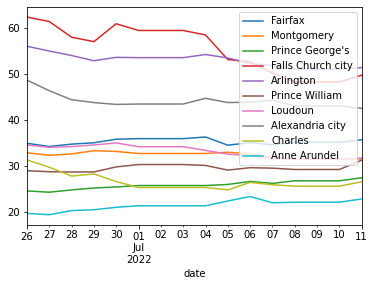

In [20]:
pops = []
places = []

for i in range(0, len(locale_dict)):
    pops.append(locale_dict[i][2])
    places.append(locale_dict[i][0])
    fips.append(locale_dict[i][3])

dmv_cases_per_100k = (((df - df.shift(1)).rolling(14).mean()).divide(pops, axis='columns') * 100_000).dropna()
dmv_cases_per_100k[-16:].plot()
dmv_cases_per_100k.tail()

In [21]:
X = dmv_cases_per_100k[:]
X = sm.add_constant(X)
y = dc_cases_per_100k[-len(X):]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  cases   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     2476.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        13:42:16   Log-Likelihood:                -2834.3
No. Observations:                 806   AIC:                             5691.
Df Residuals:                     795   BIC:                             5742.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.4542      0.482    -11.312      0.000      -6.401      -4.508
Fairfax              -2.5812      0.157    -16.439      0.000      -2.889      -2.273
Montgomery           -0.6893      0.057    -12.094      0.000      -0.801      -0.577
Prince George's       0.9739      0.053     18.428      0.000       0.870       1.078
Falls Church city    -0.1942      0.036     -5.340      0.000      -0.266      -0.123
Arlington             0.8339      0.069     12.095      0.000       0.699       0.969
Prince William        0.6867      0.083      8.276      0.000       0.524       0.850
Loudoun               0.3212      0.062      5.197      0.000       0.200       0.443
Alexandria city       1.3447      0.071     19.000      0.000       1.206       1.484
Charles               0.3227      0.054      5.934      0.000       0.216       0.429
Anne Arundel         -0.4036      0.074     -5.484      0.000      -0.548      -0.259
==============================================================================
Omnibus:                      156.050   Durbin-Watson:                   0.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1910.906
Skew:                           0.476   Prob(JB):                         0.00
Kurtosis:                      10.483   Cond. No.                         228.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse = rmse(dc_cases_per_100k[-len(X):], predictions)

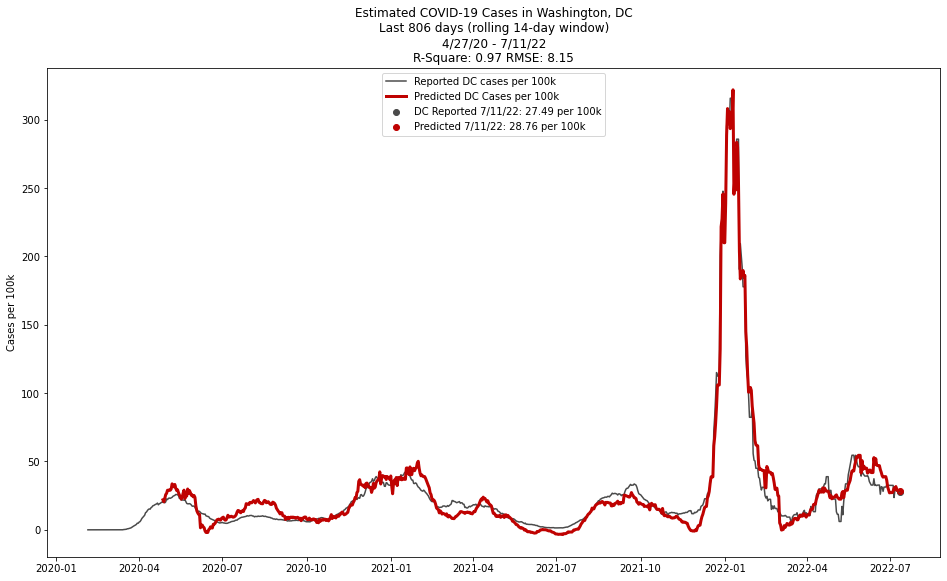

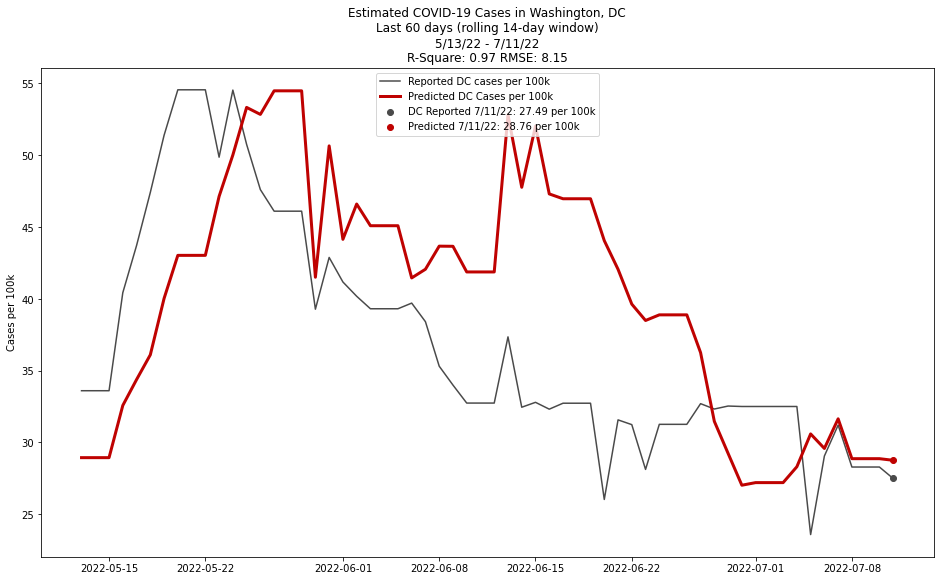

In [23]:
filenames = []
for i in [0,60]:
    lookback = i
    
    fig, ax = plt.subplots(figsize=(16,9))

    ax.plot(dc_cases_per_100k[-lookback:], color='#4A4A4A', label='Reported DC cases per 100k')
    # ax.plot(dc_cases_per_100k[-lookback:].idxmin(), dc_cases_per_100k[-lookback:].min(), marker='o', label='Actual Low {}: {}'.format(dc_cases_per_100k[-lookback:].idxmin().strftime(datestrf), round(dc_cases_per_100k[-lookback:].min(), 2)))
    # ax.text(dc_cases_per_100k.index[-1], dc_cases_per_100k[-1]-dc_cases_per_100k[-1]*.2, 'local max')
    ax.scatter(dc_cases_per_100k.index[-1], dc_cases_per_100k[-1], marker='o', color='#4A4A4A',
               label='DC Reported {}: {} per 100k'.format(dc_cases_per_100k.index[-1].strftime(datestrf), round(dc_cases_per_100k[-1:].min(), 2)))


    ax.set_title('Estimated COVID-19 Cases in Washington, DC\nLast {} days (rolling 14-day window)\n{} - {}\nR-Square: {:0.2f} RMSE: {:0.2f}'
                 .format(len(predictions.index[-lookback:]),
                         predictions.index[-lookback].strftime(datestrf),
                         predictions.index[-1].strftime(datestrf),
                         model.rsquared, rmse))
    ax.set_ylabel('Cases per 100k')
    # ax.set_xlabel('Date')
    ax.plot(predictions[-lookback:],
            label='Predicted DC Cases per 100k', color='#bf0201', linewidth=3)
    # ax.plot(predictions.rolling(14).mean()[-lookback:])
    ax.scatter(predictions.index[-1], predictions[-1], marker='o', color='#bf0201', label='Predicted {}: {} per 100k'.format(predictions.index[-1].strftime(datestrf), round(predictions[-1:].min(), 2)))

    ax.legend(loc=9)
    # ax.imshow(img, extent=[dc_cases_per_100k.index[-lookback].timestamp(),dc_cases_per_100k.index[-1].timestamp(),0,100])
    fig.savefig('estimator{}.jpg'.format(i), bbox_inches='tight')
    filenames.append('estimator{}.jpg'.format(i))

In [25]:
status = """
DC reporting {:,} new case(s), {} new death(s) on {} thru #CDC #API. 
{:,} new cases, {:,} new deaths over the last {} days.
Predicted level: {:,.2f} per 100k
Reported level: {:,.2f} per 100k
""".format(int(dc_new_cases), int(dc_new_deaths), dc_cases_per_100k.index[-1].strftime('%#m/%#d'),
          dc_df['cases'][-1]-dc_df['cases'][-90], dc_df['deaths'][-1]-dc_df['deaths'][-90], lookback,
          predictions[-1], dc_cases_per_100k[-1])
print(status.strip())
len(status)

DC reporting 507 new case(s), 0 new death(s) on 7/11 thru #CDC #API. 
19,895 new cases, 22 new deaths over the last 60 days.
Predicted level: 28.76 per 100k
Reported level: 27.49 per 100k


189

In [26]:
media_ids = []
for filename in filenames:
    res = api.media_upload(filename)
    media_ids.append(res.media_id)
api.update_status(status=status, media_ids=media_ids)

Status(_api=<tweepy.api.API object at 0x00000237781B6310>, _json={'created_at': 'Tue Jul 12 17:43:09 +0000 2022', 'id': 1546913063529578496, 'id_str': '1546913063529578496', 'text': 'DC reporting 507 new case(s), 0 new death(s) on 7/11 thru #CDC #API. \n19,895 new cases, 22 new deaths over the last… https://t.co/S3m5gljqbz', 'truncated': True, 'entities': {'hashtags': [{'text': 'CDC', 'indices': [58, 62]}, {'text': 'API', 'indices': [63, 67]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/S3m5gljqbz', 'expanded_url': 'https://twitter.com/i/web/status/1546913063529578496', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}, 'source': '<a href="http://www.twitter.com" rel="nofollow">python_automator</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1514320481817612293, 'id_str': '1514320481817612293', 'name': 'Junior

In [6]:
# collect hospitalization data from CDC
lst = []

for i in range(0,len(fips_dc)):
    url = 'https://healthdata.gov/resource/anag-cw7u.json?fips_code={}'.format(fips_dc[i])
    json = requests.get(url).json()
    lst.append(json)
len(lst)

11

In [7]:
total_beds = 'inpatient_beds_7_day_avg'
beds_used = 'inpatient_beds_used_7_day_avg'
covid_pos_sus_adults = 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'
covid_pos_sus_kids = 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'
covid_pos_sus_total = 'total_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'

hospital_df = pd.concat([pd.DataFrame(lst[0]),
           pd.DataFrame(lst[1]),
           pd.DataFrame(lst[2]),
           pd.DataFrame(lst[3]),
           pd.DataFrame(lst[4]),
           pd.DataFrame(lst[5]),
           pd.DataFrame(lst[6]),
           pd.DataFrame(lst[7]),
           pd.DataFrame(lst[8]),
           pd.DataFrame(lst[9]),
           pd.DataFrame(lst[10]),
          ]).astype({
                      total_beds:'float64',
                      beds_used:'float64',
                      covid_pos_sus_adults:'float64',
                      covid_pos_sus_kids:'float64'
                      })

hospital_df['collection_week'] = pd.to_datetime(hospital_df['collection_week'])
hospital_df.loc[hospital_df[covid_pos_sus_adults] == -999999.0, covid_pos_sus_adults] = 0
hospital_df.loc[hospital_df[covid_pos_sus_kids] == -999999.0, covid_pos_sus_kids] = 0
hospital_df[covid_pos_sus_total] = hospital_df[covid_pos_sus_adults] + hospital_df[covid_pos_sus_kids]
hospital_df.groupby('fips_code')['collection_week'].max()

fips_code
11001   2022-07-01
24003   2022-07-01
24017   2022-07-01
24031   2022-07-01
24033   2022-07-01
51013   2022-07-01
51059   2022-07-01
51107   2022-07-01
51153   2022-07-01
51510   2022-07-01
Name: collection_week, dtype: datetime64[ns]

In [8]:
sums_df = hospital_df.groupby('collection_week').sum()[4:]

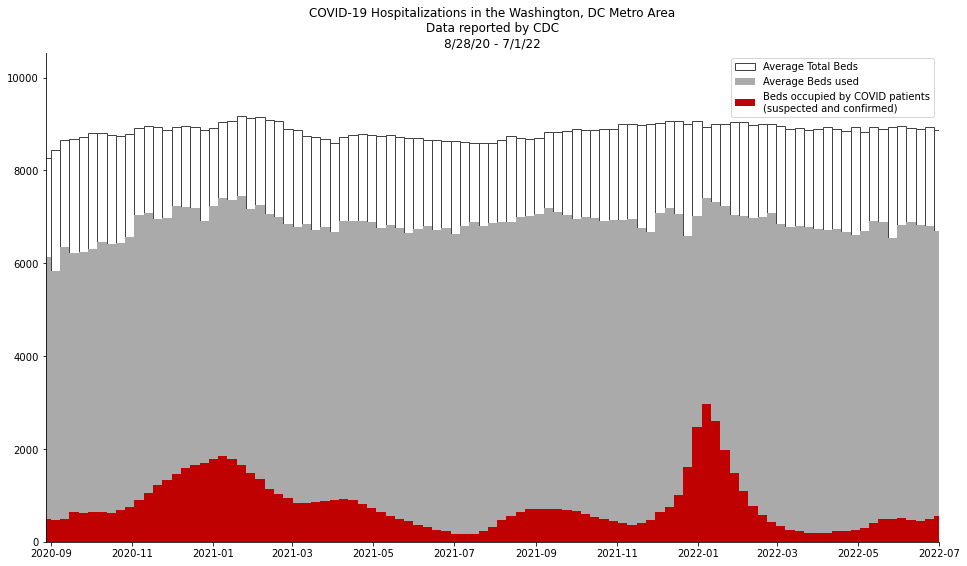

In [9]:
fig, ax = plt.subplots(figsize=(16,9))

width = 7
ax.bar(sums_df[total_beds].index, 
       sums_df[total_beds].values,
      width=width, edgecolor='#444444', color='#ffffff', label='Average Total Beds')

ax.bar(sums_df[beds_used].index, 
       sums_df[beds_used].values,
      width=width, color='#aaaaaa', label='Average Beds used')

ax.bar(sums_df[covid_pos_sus_total].index, 
       sums_df[covid_pos_sus_total].values,
      width=width, color='#bf0201', label='Beds occupied by COVID patients\n(suspected and confirmed)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([sums_df.index[0], sums_df.index[-1]])
ax.set_ylim([0, sums_df.values.max() * 1.15])
ax.set_title('COVID-19 Hospitalizations in the Washington, DC Metro Area\nData reported by CDC\n{} - {}'
             .format(sums_df.index[0].strftime(datestrf), 
                     sums_df.index[-1].strftime(datestrf)))
ax.legend(loc=0)
fig.savefig('hospitals.jpg', bbox_inches='tight')

In [12]:
pct_beds_occ = sums_df.iloc[-1,0] / sums_df.iloc[-1,3] * 100
beds_occ_pct_change = ((sums_df.iloc[-1,0] / sums_df.iloc[-1,3]) / (sums_df.iloc[-2,0] / sums_df.iloc[-2,3]) -1) * 100
pct_beds_occ_covid = sums_df.iloc[-1,5] / sums_df.iloc[-1,3] *100
covid_beds_pct_change = ((sums_df.iloc[-1,5] / sums_df.iloc[-1,3]) / (sums_df.iloc[-2,5] / sums_df.iloc[-2,3]) -1) *100
status = """Graphing #DC area #hospitalizations for #COVID week of {}:
% of beds occupied: {:.2f}% ({:+.2f}% prev week)
% of beds occupied by COVID-19 cases: {:.2f}% ({:+.2f}% prev week)
""".format(sums_df.index[-1].strftime(datestrf), pct_beds_occ, beds_occ_pct_change, pct_beds_occ_covid, covid_beds_pct_change)

print(status,len(status))
filename = 'hospitals.jpg'
api.update_status_with_media(status, filename)

Graphing #DC area #hospitalizations for #COVID week of 7/1/22:
% of beds occupied: 75.55% (-0.71% prev week)
% of beds occupied by COVID-19 cases: 6.22% (+11.31% prev week)
 173


Status(_api=<tweepy.api.API object at 0x00000237783B3EE0>, _json={'created_at': 'Mon Jul 11 19:24:01 +0000 2022', 'id': 1546576060518653953, 'id_str': '1546576060518653953', 'text': 'Graphing #DC area #hospitalizations for #COVID week of 7/1/22:\n% of beds occupied: 75.55% (-0.71% prev week)\n% of b… https://t.co/5NAttt2nsD', 'truncated': True, 'entities': {'hashtags': [{'text': 'DC', 'indices': [9, 12]}, {'text': 'hospitalizations', 'indices': [18, 35]}, {'text': 'COVID', 'indices': [40, 46]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/5NAttt2nsD', 'expanded_url': 'https://twitter.com/i/web/status/1546576060518653953', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}, 'source': '<a href="http://www.twitter.com" rel="nofollow">python_automator</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 15143204818176122